In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from transformers import MarianMTModel, MarianTokenizer
from nltk.corpus import wordnet as wn
import random
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

# Set seed for reproducibility
np.random.seed(100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# load the dataset
import csv
augmented_dataset = pd.read_csv('/content/augmented_dataset.csv')

## Data Visualization

In [ ]:
# 1. Total Samples
total_samples = augmented_dataset.shape[0]
print(f"Numero totale di campioni nel dataset: {total_samples}")

Numero totale di campioni nel dataset: 120000


In [ ]:
# 2. Unique 'genre' values ​​(unique labels for classification)
unique_genres = augmented_dataset['genre'].unique()
print(f"Generi unici nel dataset: {unique_genres}")

Generi unici nel dataset: ['Pop' 'Hip-Hop' 'Rock' 'Metal']



Distribuzione dei generi (numero di campioni per genere):
genre
Pop        30000
Hip-Hop    30000
Rock       30000
Metal      30000
Name: count, dtype: int64


<ipython-input-6-b587ea9d4810>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette="viridis")


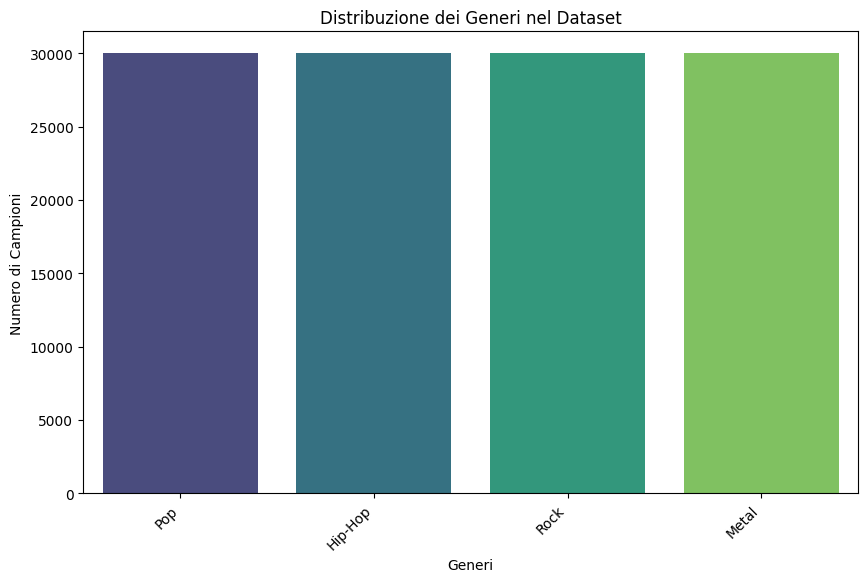

In [ ]:
# 3. Genres Distribution
genre_distribution =  augmented_dataset['genre'].value_counts()
print("\nDistribuzione dei generi (numero di campioni per genere):")
print(genre_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette="viridis")
plt.title("Distribuzione dei Generi nel Dataset")
plt.xlabel("Generi")
plt.ylabel("Numero di Campioni")
plt.xticks(rotation=45, ha='right')
plt.show()

## Preprocessing

In [ ]:
# Remove stop words
stop = stopwords.words('english')
augmented_dataset['lyrics'] = augmented_dataset['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

In [ ]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

augmented_dataset['lyrics'] = augmented_dataset['lyrics'].apply(lemmatize_text)

In [ ]:
# Encode genres
Y = augmented_dataset['genre']
Y = LabelEncoder().fit_transform(Y)
augmented_dataset['Y'] = Y.tolist()

In [ ]:
# Split the dataset into training and testing balancing classes with stratify
X_train, X_test, y_train, y_test = train_test_split(
    augmented_dataset['lyrics'],
    augmented_dataset['Y'],
    test_size=0.20,
    random_state=42,
    stratify=augmented_dataset['Y']
)

In [ ]:
# training set genres distribution
print("Distribuzione dei generi nel training set:")
print(y_train.value_counts(normalize=True))

# test set genres distribution
print("\nDistribuzione dei generi nel test set:")
print(y_test.value_counts(normalize=True))

Distribuzione dei generi nel training set:
Y
1    0.25
3    0.25
0    0.25
2    0.25
Name: proportion, dtype: float64

Distribuzione dei generi nel test set:
Y
2    0.25
1    0.25
0    0.25
3    0.25
Name: proportion, dtype: float64


In [ ]:
# Hugging Face BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenization and Dataset preparation
class LyricsDataset(Dataset):
    def __init__(self, lyrics, labels, tokenizer, max_len=512):
        self.lyrics = lyrics
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, item):
        text = self.lyrics[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = LyricsDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = LyricsDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

## Modeling

In [ ]:
# dropout
config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=4,  # Numero di classi
    hidden_dropout_prob=0.2,  # Aumenta il dropout
    attention_probs_dropout_prob=0.2  # Dropout per l'attenzione
)

In [ ]:
# Bert model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [ ]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # Probabilità predetta per il target corretto
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
criterion = FocalLoss(alpha=1, gamma=2)

In [ ]:
# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop with loss tracking
epochs = 9
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f'Epoch {epoch + 1} - Training Loss: {epoch_train_loss:.4f}')

    # Evaluation loop with loss tracking for validation set
    model.eval()
    epoch_val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            epoch_val_loss += loss.item()

            # Get predictions
            _, preds = torch.max(logits, dim=1)

            # Store true labels and predictions
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_val_loss /= len(test_loader)
    val_losses.append(epoch_val_loss)
    print(f'Epoch {epoch + 1} - Validation Loss: {epoch_val_loss:.4f}')

    # Early stopping logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss  # Update best validation loss
        epochs_without_improvement = 0  # Reset the counter if we find an improvement
    else:
        epochs_without_improvement += 1  # Increment the counter if no improvement

    # If no improvement for 'patience' epochs, stop early
    if epochs_without_improvement >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
        epochs_completed = epoch + 1  # Save the number of epochs completed before stopping
        break



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1 - Training Loss: 0.3334
Epoch 1 - Validation Loss: 0.2951
Epoch 2 - Training Loss: 0.2723
Epoch 2 - Validation Loss: 0.2940
Epoch 3 - Training Loss: 0.2236
Epoch 3 - Validation Loss: 0.2983
Epoch 4 - Training Loss: 0.1779
Epoch 4 - Validation Loss: 0.3286
Epoch 5 - Training Loss: 0.1402
Epoch 5 - Validation Loss: 0.3651
Epoch 6 - Training Loss: 0.1128
Epoch 6 - Validation Loss: 0.4020
Epoch 7 - Training Loss: 0.0918
Epoch 7 - Validation Loss: 0.4401
Early stopping triggered after 7 epochs without improvement.


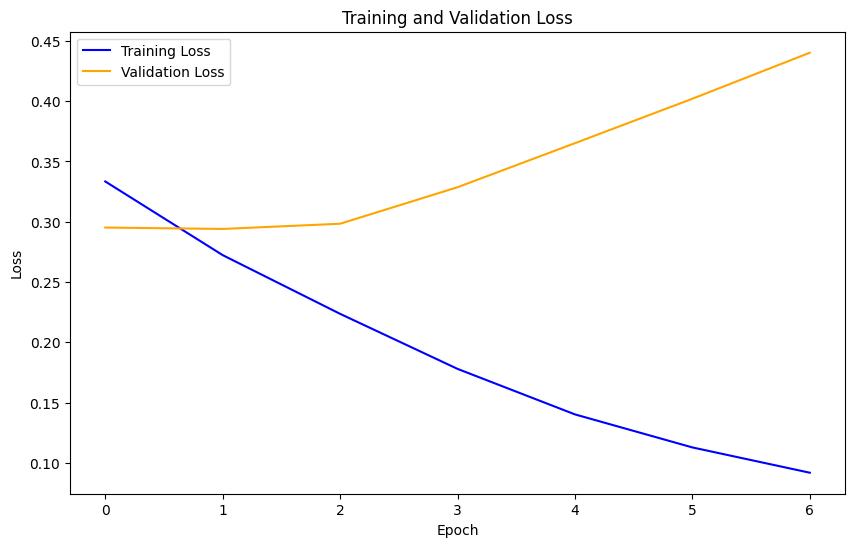

In [ ]:
# If early stopping doesn't trigger, we just complete all epochs
if epochs_without_improvement < patience:
    epochs_completed = epochs

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(epochs_completed), train_losses[:epochs_completed], label='Training Loss', color='blue')
plt.plot(range(epochs_completed), val_losses[:epochs_completed], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Confusion Matrix:
[[4920  218  559  303]
 [ 180 4826  234  760]
 [ 205  294 4043 1458]
 [  95  737 1667 3501]]


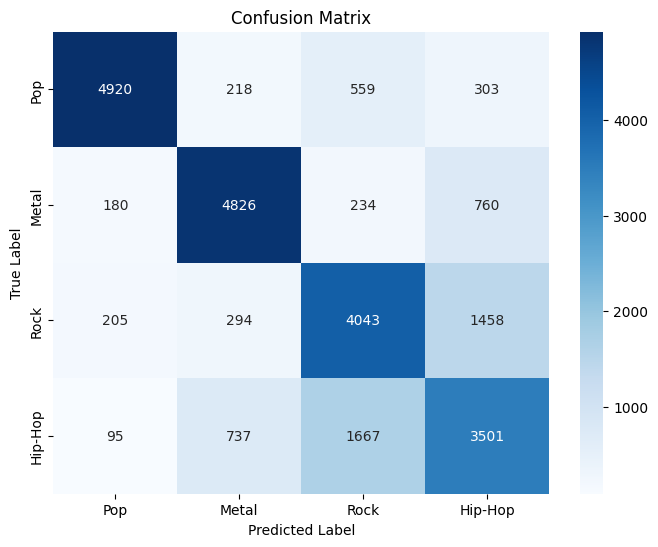

Classification Report:
              precision    recall  f1-score   support

         Pop       0.91      0.82      0.86      6000
       Metal       0.79      0.80      0.80      6000
        Rock       0.62      0.67      0.65      6000
     Hip-Hop       0.58      0.58      0.58      6000

    accuracy                           0.72     24000
   macro avg       0.73      0.72      0.72     24000
weighted avg       0.73      0.72      0.72     24000

Precision: 0.7271
Recall: 0.7204
F1-Score: 0.7229


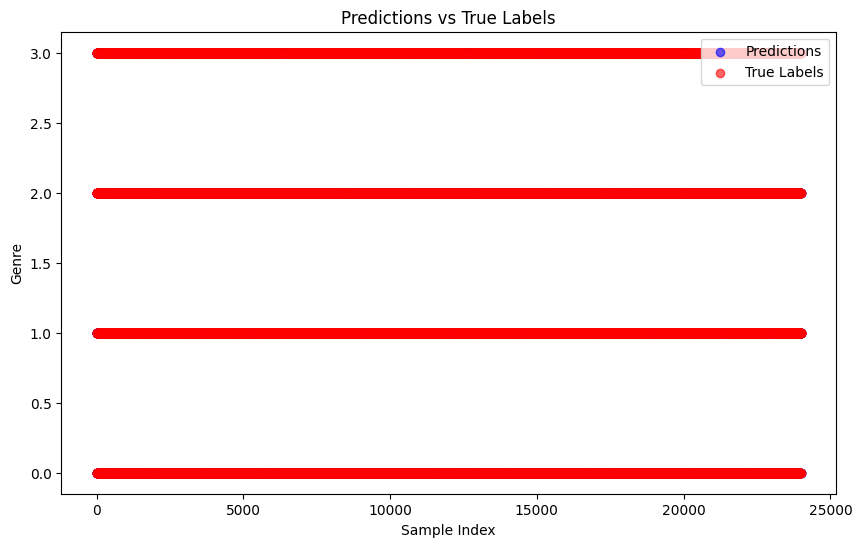

In [ ]:
# After the loop, compute the confusion matrix and other metrics
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Pop", "Metal", "Rock", "Hip-Hop"],
            yticklabels=["Pop", "Metal", "Rock", "Hip-Hop"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(all_labels, all_preds, target_names=["Pop", "Metal", "Rock", "Hip-Hop"])
print("Classification Report:")
print(class_report)

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Plot predictions vs true labels
plt.figure(figsize=(10, 6))
plt.scatter(range(len(all_preds)), all_preds, color='blue', label='Predictions', alpha=0.6)
plt.scatter(range(len(all_labels)), all_labels, color='red', label='True Labels', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Genre')
plt.title('Predictions vs True Labels')
plt.legend(loc='upper right')
plt.show()